<a href="https://colab.research.google.com/github/ErfanRasti/MachineLearningProjects/blob/main/NaturalLanguageProcessing/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='green'>NLP Project</font>

<div class="alert alert-block alert-warning">
<b>
Amirkabir University of Technology<br>
Fall 2022<br>
Course: Machine Learning<br>
Instructor: Dr. Seyedin<br>
<b><font color='green'>Authors:</font></b><br>
Name: Amir Azad <br />
Student Number: 9823004 <br />
Name: Erfan Rasti <br />
Student Number: 9823034 </div>


***

# <font color='purple'>Importing Required Packages</font>

In [1]:
# ! pip install transformers
# ! pip install datasets
# ! pip install sentence-transformers
# ! pip install evaluate


In [2]:
# from transformers import AutoTokenizer
import pandas as pd
import torch
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn import metrics
from sentence_transformers import SentenceTransformer
from transformers import TrainingArguments, Trainer
from transformers import DistilBertForSequenceClassification
from transformers import DistilBertTokenizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package stopwords to /home/erfan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# <font color='purple'>Loading the dataset from Hugging Face</font>

In [15]:
from datasets import load_dataset
dataset = load_dataset('tweet_eval', 'hate')

Found cached dataset tweet_eval (/home/erfan/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

In [16]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2970
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
})


In [17]:
print(dataset['train'][0])
print(dataset['test'][2])

{'text': '@user nice new signage. Are you not concerned by Beatlemania -style hysterical crowds crongregating on you…', 'label': 0}
{'text': '@user @user Those People Invaded Us!!! They DO NOT BELING HERE & HAVE NO RIGHTS! Its #AmericaFIRST! Open Your House To Them If Your That IGNORANT! & Yes Im A #Christian Too! #NODACA!', 'label': 1}


# <font color='purple'>Preprocessing Data</font>


In [18]:
def preprocess_sentence(sentence):
    # remove punctuation
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    # remove numbers
    sentence = re.sub(r'\d+', '', sentence)
    # remove whitespace
    sentence = sentence.strip()
    # remove stopwords
    sentence = ' '.join([word for word in sentence.split()
                        if word not in stopwords.words('english')])
    return sentence


In [19]:
def preprocess_dataset(dataset):
    dataset = dataset.map(
        lambda examples: {'text': preprocess_sentence(examples['text'])})
    return dataset


In [20]:
dataset = preprocess_dataset(dataset)
print(dataset['train'][0])
print(dataset['test'][2])

  0%|          | 0/9000 [00:00<?, ?ex/s]

  0%|          | 0/2970 [00:00<?, ?ex/s]

  0%|          | 0/1000 [00:00<?, ?ex/s]

{'text': 'user nice new signage Are concerned Beatlemania style hysterical crowds crongregating you…', 'label': 0}
{'text': 'user user Those People Invaded Us They DO NOT BELING HERE HAVE NO RIGHTS Its AmericaFIRST Open Your House To Them If Your That IGNORANT Yes Im A Christian Too NODACA', 'label': 1}


In [45]:
# You can use bert-base or DistilBert as a model
tokenizer = DistilBertTokenizer.from_pretrained(
    'distilbert-base-cased')

def tokenize_dataset(dataset):
    tokenized_dataset = dataset.map(lambda examples: tokenizer(
        examples['text'], truncation=True, padding='max_length'), batched=True)
    return tokenized_dataset


loading file vocab.txt from cache at /home/erfan/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/9d7568e4b20ed5db15ee30e99c7219bde9990762/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /home/erfan/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/9d7568e4b20ed5db15ee30e99c7219bde9990762/tokenizer_config.json
loading configuration file config.json from cache at /home/erfan/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/9d7568e4b20ed5db15ee30e99c7219bde9990762/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_drop

In [46]:
dataset = tokenize_dataset(dataset)
print(dataset['train'][0])
print(dataset['validation'][0])
print(dataset['test'][2])

Loading cached processed dataset at /home/erfan/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-1c80317fa3b1799d.arrow
Loading cached processed dataset at /home/erfan/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-bdd640fb06671ad1.arrow
Loading cached processed dataset at /home/erfan/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-3eb13b9046685257.arrow


{'text': 'user nice new signage Are concerned Beatlemania style hysterical crowds crongregating you…', 'label': 0, 'input_ids': [101, 4795, 3505, 1207, 2951, 2553, 2372, 4264, 11938, 14183, 11262, 1947, 177, 21878, 4571, 13484, 172, 16822, 1874, 18401, 1128, 795, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# <font color='purple'>Fine-tune a model</font>

You should complete this section

In [56]:
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-cased',
    num_labels=2,
    n_layers=4,
    dropout=0.3,
)

training_args = TrainingArguments(output_dir="test_trainer",
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  save_total_limit=1,
                                  learning_rate=1e-5,
                                  num_train_epochs=3,
                                  weight_decay=0.01,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=8,
                                  load_best_model_at_end=True,
                                  optim="adamw_torch")


loading configuration file config.json from cache at /home/erfan/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/9d7568e4b20ed5db15ee30e99c7219bde9990762/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "attention_dropout": 0.2,
  "dim": 768,
  "dropout": 0.2,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 4,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.2,
  "seq_classif_dropout": 0.3,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 28996
}

loading weights file pytorch_model.bin from cache at /home/erfan/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/9d7568e4b20ed5db15ee30e99c7219bde9990762/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['distilbert.transforme

In [57]:
import numpy as np
import evaluate


metrics_to_compute = evaluate.combine([
    evaluate.load("accuracy"),
    evaluate.load("precision", average='weighted'),
    evaluate.load("recall", average='weighted'),
    evaluate.load("f1", average='weighted')
])


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metrics_to_compute.compute(predictions, labels)


In [58]:
# ! rm -rf test_trainer

In [59]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    compute_metrics=compute_metrics,
)

trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 9000
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 6750
  Number of trainable parameters = 51607298


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.545200,0.536952,0.738000,0.693208,0.693208,0.693208
2,0.483100,0.707301,0.739000,0.662745,0.791569,0.721451
3,0.458300,0.803892,0.742000,0.660952,0.812646,0.728992


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 2
Saving model checkpoint to test_trainer/checkpoint-2250
Configuration saved in test_trainer/checkpoint-2250/config.json
Model weights saved in test_trainer/checkpoint-2250/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 2
Saving model checkpoint to test_trainer/checkpoint-4500
Configuration saved in test_trainer/checkpoint-4500/config.json
Model weig

TrainOutput(global_step=6750, training_loss=0.5101035653573496, metrics={'train_runtime': 719.7821, 'train_samples_per_second': 37.511, 'train_steps_per_second': 9.378, 'total_flos': 2400826853376000.0, 'train_loss': 0.5101035653573496, 'epoch': 3.0})

In [16]:
! zip -r test_trainer.zip test_trainer

  adding: test_trainer/ (stored 0%)
  adding: test_trainer/checkpoint-5500/ (stored 0%)
  adding: test_trainer/checkpoint-5500/scheduler.pt (deflated 49%)
  adding: test_trainer/checkpoint-5500/optimizer.pt (deflated 27%)
  adding: test_trainer/checkpoint-5500/rng_state.pth (deflated 28%)
  adding: test_trainer/checkpoint-5500/config.json (deflated 46%)
  adding: test_trainer/checkpoint-5500/training_args.bin (deflated 49%)
  adding: test_trainer/checkpoint-5500/pytorch_model.bin (deflated 8%)
  adding: test_trainer/checkpoint-5500/trainer_state.json (deflated 78%)
  adding: test_trainer/checkpoint-3500/ (stored 0%)
  adding: test_trainer/checkpoint-3500/scheduler.pt (deflated 49%)
  adding: test_trainer/checkpoint-3500/optimizer.pt (deflated 27%)
  adding: test_trainer/checkpoint-3500/rng_state.pth (deflated 28%)
  adding: test_trainer/checkpoint-3500/config.json (deflated 46%)
  adding: test_trainer/checkpoint-3500/training_args.bin (deflated 49%)
  adding: test_trainer/checkpoint-35

# <font color='purple'>Evaluation</font>

You should complete this section

In [26]:
# model = torch.load('test_trainer/checkpoint-2000/pytorch_model.bin')

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2970
  Batch size = 2


Accuracy:  0.469023569023569
Precision:  0.6003773829112637
Recall:  0.469023569023569
F1:  0.3825528787781072
ROC AUC:  0.5311785194910494


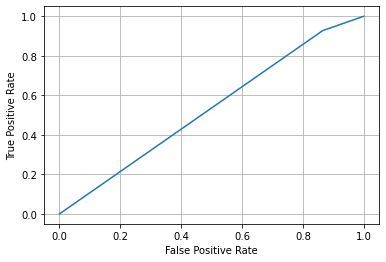

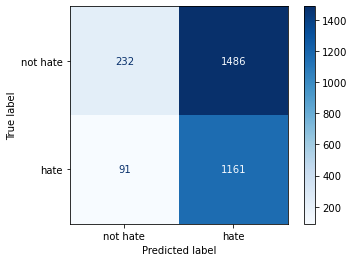

In [60]:
test_pred = trainer.predict(dataset['test']).predictions.argmax(axis=1)
test_true = dataset['test']['label']

print('Accuracy: ', accuracy_score(test_true, test_pred))
print('Precision: ', precision_score(test_true, test_pred, average='weighted'))
print('Recall: ', recall_score(test_true, test_pred, average='weighted'))
print('F1: ', f1_score(test_true, test_pred, average='weighted'))
print('ROC AUC: ', roc_auc_score(test_true, test_pred))

fpr, tpr, thresholds = roc_curve(test_true, test_pred)
roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_plot.plot()
plt.grid()
plt.show()

cm = confusion_matrix(test_true, test_pred)
cm_plot = ConfusionMatrixDisplay(
    cm, display_labels=['not hate', 'hate'])
cm_plot.plot(cmap='Blues')
plt.show()


# <font color='purple'>References</font>

1.   https://huggingface.co/metrics
2.   https://huggingface.co/docs/transformers/training
